# Análise de Mercado do Airbnb no Rio de Janeiro
![](https://i0.wp.com/viajandonajanela.com/wp-content/uploads/2020/09/airbnb-praia-rio-de-janeiro-RJ-capa.jpg?fit=1440%2C810&ssl=1)
Um guia para quem quer alugar melhor (e mais caro)
>História em uma frase:
>
>“No Rio, o mesmo apartamento pode custar 120 ou 1.200 a noite – a diferença está nos dados.”

O mercado de aluguel por temporada no Rio de Janeiro é fascinante e complexo. Com milhares de propriedades disputando a atenção dos turistas, uma pergunta ecoa pelos corredores dos apartamentos em Copacabana e Ipanema: "*Como posso maximizar minha receita?*"

Neste notebook, vamos mergulhar nos dados reais do Airbnb para descobrir os segredos dos anfitriões mais bem-sucedidos. Prepare-se para insights que podem transformar sua estratégia de hospedagem!

<br>**Links úteis**

- **Dados**: https://insideairbnb.com/get-the-data/
- **Dicionário dos Dados**: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596

<br>**Autor**: Wellington M Santos - Cientista de Dados
<br>**Linkedin**: [/in/wellington-moreira-santos](https://www.linkedin.com/in/wellington-moreira-santos/)

In [4]:
# Dependencias e configurações
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# configuraçoes pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# configurações matplotlib e seaborn
plt.style.use('default')
sns.set_palette("husl")

# versoes
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
Matplotlib: 3.10.0
Seaborn: 0.13.2


## Capítulo 1: Coletando as Evidências
Nossos dados vêm diretamente do Inside Airbnb, uma fonte confiável que coleta informações públicas da plataforma. Vamos carregar informações de mais de 40 mil propriedades cadastradas no Rio.

In [5]:
# Carregamento dos dados - direto da fonte oficial
print("Carregando dados do mercado carioca...")
url = "https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz"
df = pd.read_csv(url, compression='gzip')

# Selecionando apenas as colunas que realmente importam para nossa análise
colunas = ['id','host_id','neighbourhood_cleansed','latitude','longitude',
           'property_type','room_type','accommodates','bedrooms','price',
           'minimum_nights','host_is_superhost','number_of_reviews',
           'number_of_reviews_ltm','review_scores_rating','review_scores_value',
           'availability_365']

data = df[colunas].copy()
print(f"✅ {len(data):,} propriedades carregadas!")

Carregando dados do mercado carioca...
✅ 42,013 propriedades carregadas!


In [30]:
# Uma visão Geral
print(f"Dimensões: {data.shape[0]:,} propriedades × {data.shape[1]} características")
print()
data.head()

Dimensões: 38,356 propriedades × 17 características



,id,host_id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,price,minimum_nights,host_is_superhost,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_value,availability_365
0,2302715,11706874,Anil,-22.95221,-43.32944,Entire home,Entire home/apt,12,5,2700.0,10,False,0,0,NaN,NaN,365
1,2304688,10405816,Ipanema,-22.98767,-43.18991,Entire rental unit,Entire home/apt,4,2,837.0,7,False,0,0,NaN,NaN,365
2,2306547,4107346,Copacabana,-22.97333,-43.18857,Entire rental unit,Entire home/apt,7,3,800.0,5,False,13,3,5.00,4.77,257
3,2306767,11386725,Copacabana,-22.96477,-43.17605,Entire rental unit,Entire home/apt,3,0,190.0,3,False,193,19,4.69,4.65,66
4,2308385,11788583,Copacabana,-22.96820,-43.18523,Entire rental unit,Entire home/apt,4,1,220.0,2,False,28,4,4.89,4.75,242


In [33]:
# Informações do dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38356 entries, 0 to 42012
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      38356 non-null  int64  
 1   host_id                 38356 non-null  int64  
 2   neighbourhood_cleansed  38356 non-null  object 
 3   latitude                38356 non-null  float64
 4   longitude               38356 non-null  float64
 5   property_type           38356 non-null  object 
 6   room_type               38356 non-null  object 
 7   accommodates            38356 non-null  int64  
 8   bedrooms                38356 non-null  int64  
 9   price                   38356 non-null  float64
 10  minimum_nights          38356 non-null  int64  
 11  host_is_superhost       37225 non-null  object 
 12  number_of_reviews       38356 non-null  int64  
 13  number_of_reviews_ltm   38356 non-null  int64  
 14  review_scores_rating    30356 non-null  flo

## Capítulo 2: A Arte da Limpeza de Dados
Como um arqueólogo que limpa cuidadosamente cada artefato, precisamos preparar nossos dados. Preços vêm com símbolos de dólar, alguns campos estão vazios, e outliers podem distorcer nossa análise.

In [6]:
print("=== Iniciando a limpeza dos dados ===")

# O preço vem como string com "$" e vírgulas - vamos transformar em número
data['price'] = (data['price']
                 .astype(str)
                 .str.replace(r'[\$,]', '', regex=True)
                 .replace('', np.nan)
                 .astype(float))

# Remove propriedades sem preço (não servem para nossa análise)
data = data.dropna(subset=['price'])

# Tratamento de outros campos importantes
data['bedrooms'] = data['bedrooms'].fillna(0).astype(int)
data['host_is_superhost'] = data['host_is_superhost'].map({'t': True, 'f': False})
data['accommodates'] = data['accommodates'].fillna(1).astype(int)

# Padronizar nomes das colunas
data.columns = data.columns.str.lower()

print(f"{len(data):,} anúncios válidos após a limpeza")

=== Iniciando a limpeza dos dados ===
38,356 anúncios válidos após a limpeza


In [8]:
print("\n=== Investigando a Qualidade dos Dados ===")
print(f"Dimensões: {data.shape[0]:,} propriedades × {data.shape[1]} características")

print(f"\nDados faltantes (%):")
missing_pct = data.isnull().mean() * 100
missing_data = missing_pct[missing_pct > 0].sort_values(ascending=False).round(1)
for col, pct in missing_data.items():
    print(f"   • {col}: {pct}%")


=== Investigando a Qualidade dos Dados ===
Dimensões: 38,356 propriedades × 17 características

Dados faltantes (%):
   • review_scores_value: 20.9%
   • review_scores_rating: 20.9%
   • host_is_superhost: 2.9%


## Capítulo 3: Eliminando os Extremos
Nem todo preço faz sentido. Uma propriedade por R$ 50.000/noite pode ser real, mas distorce nossa análise. Vamos focar no mercado "real" - aquele onde 98% das transações acontecem.

In [9]:
# Identificando outliers de preço
q1, q99 = data['price'].quantile([0.01, 0.99])
print(f"Faixa de preços do mercado real:")
print(f"   • 1% mais barato: R$ {q1:.0f}")
print(f"   • 99% mais caro: R$ {q99:.0f}")

# Criando dataset limpo focado no mercado real
df_limpo = data.query(f'{q1} <= price <= {q99} and minimum_nights <= 30').copy()

# Calculando taxa de ocupação (métrica crucial para rentabilidade)
df_limpo['occupancy_rate'] = (365 - df_limpo['availability_365']) / 365
df_limpo['occupancy_rate'] = df_limpo['occupancy_rate'].clip(0, 1)

print(f"Dataset final: {df_limpo.shape[0]:,} propriedades no mercado real")

Faixa de preços do mercado real:
   • 1% mais barato: R$ 77
   • 99% mais caro: R$ 6414
Dataset final: 37,420 propriedades no mercado real


## Capítulo 4: O Panorama dos Preços
Chegou a hora da verdade: como se comportam os preços no Rio? A distribuição revela padrões interessantes sobre o mercado.

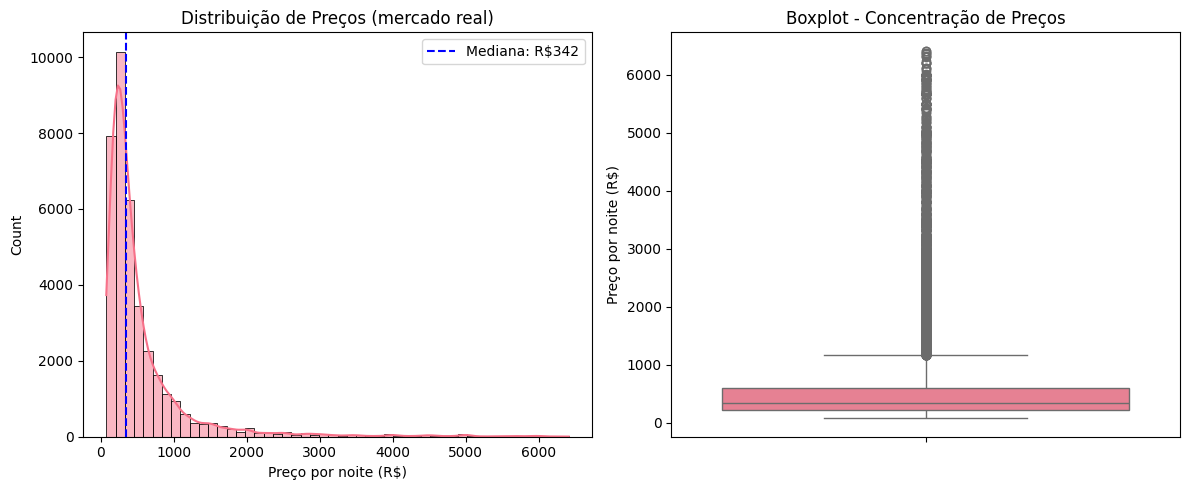

A mediana de R$342 mostra onde está o 'centro' do mercado


In [11]:
# Visualizando a distribuição de preços
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_limpo, x='price', bins=50, kde=True)
plt.axvline(df_limpo['price'].median(), color='blue', linestyle='--',
            label=f'Mediana: R${df_limpo["price"].median():.0f}')
plt.title('Distribuição de Preços (mercado real)')
plt.xlabel('Preço por noite (R$)')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=df_limpo, y='price')
plt.title('Boxplot - Concentração de Preços')
plt.ylabel('Preço por noite (R$)')

plt.tight_layout()
plt.show()

print(f"A mediana de R${df_limpo['price'].median():.0f} mostra onde está o 'centro' do mercado")

## Capítulo 5: A Geografia do Dinheiro
No Rio, localização não é tudo - é a única coisa que importa. Vamos descobrir quais bairros fazem os anfitriões sorrirem no banco.

In [12]:
print("\n=== MAPEAMENTO DOS BAIRROS MAIS LUCRATIVOS ===")

# Focando nos 15 bairros com mais propriedades
top_bairros = df_limpo['neighbourhood_cleansed'].value_counts().head(15).index

# Calculando métricas essenciais por bairro
bairros_stats = (df_limpo[df_limpo['neighbourhood_cleansed'].isin(top_bairros)]
                 .groupby('neighbourhood_cleansed')
                 .agg({
                     'price': ['median', 'mean', 'count'],
                     'occupancy_rate': 'mean',
                     'review_scores_rating': 'mean'
                 }).round(2))

# Simplificando os nomes das colunas
bairros_stats.columns = ['mediana_preco', 'media_preco', 'qtd_anuncios',
                        'ocupacao_media', 'nota_media']
bairros_stats = bairros_stats.sort_values('mediana_preco', ascending=False)

print("\n10 BAIRROS - Preço Mediano:")
for i, (bairro, dados) in enumerate(bairros_stats.head(10).iterrows(), 1):
    print(f"{i:2d}. {bairro}: R$ {dados['mediana_preco']:.0f} "
          f"({dados['qtd_anuncios']:.0f} propriedades)")


=== MAPEAMENTO DOS BAIRROS MAIS LUCRATIVOS ===

10 BAIRROS - Preço Mediano:
 1. Leblon: R$ 596 (1677 propriedades)
 2. Ipanema: R$ 561 (3301 propriedades)
 3. Barra da Tijuca: R$ 480 (3369 propriedades)
 4. Leme: R$ 354 (736 propriedades)
 5. Recreio dos Bandeirantes: R$ 351 (2011 propriedades)
 6. Jacarepaguá: R$ 339 (1701 propriedades)
 7. Copacabana: R$ 333 (11753 propriedades)
 8. Laranjeiras: R$ 290 (517 propriedades)
 9. Flamengo: R$ 277 (813 propriedades)
10. Botafogo: R$ 270 (1604 propriedades)


=== Visualizando o mapa da riqueza ===


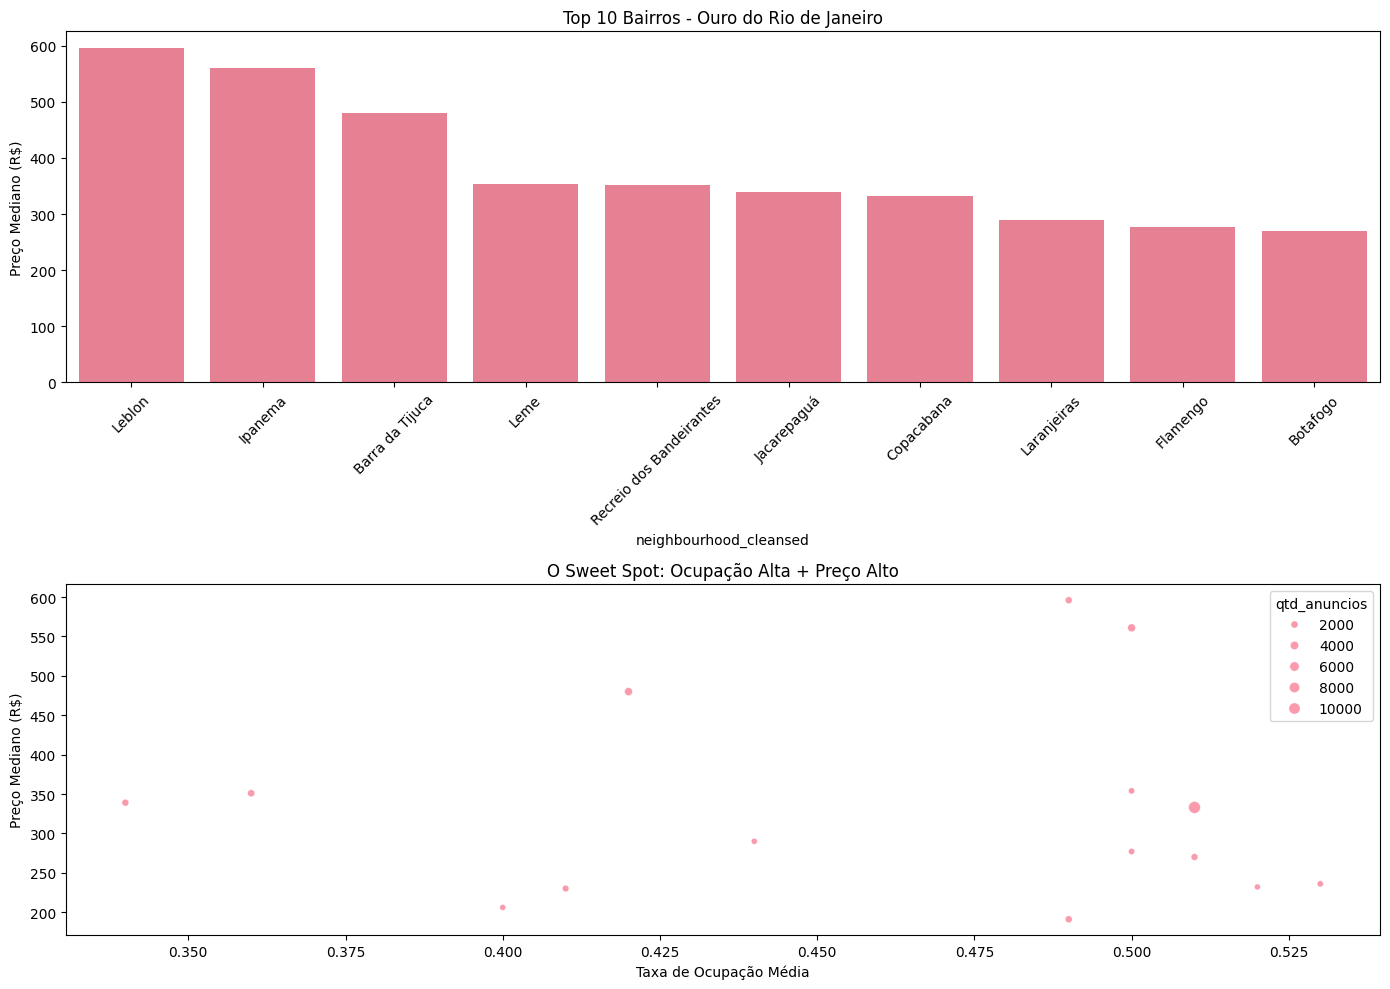

In [14]:
print("=== Visualizando o mapa da riqueza ===")

# Criando um mapa interativo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top 10 bairros por preço
top_10_bairros = bairros_stats.head(10)
sns.barplot(data=top_10_bairros.reset_index(),
           x='neighbourhood_cleansed', y='mediana_preco', ax=ax1)
ax1.set_title('Top 10 Bairros - Ouro do Rio de Janeiro')
ax1.set_ylabel('Preço Mediano (R$)')
ax1.tick_params(axis='x', rotation=45)

# Relação ocupação vs preço (o santo graal dos anfitriões)
sns.scatterplot(data=bairros_stats.reset_index(),
               x='ocupacao_media', y='mediana_preco',
               size='qtd_anuncios', ax=ax2, alpha=0.7)
ax2.set_title('O Sweet Spot: Ocupação Alta + Preço Alto')
ax2.set_xlabel('Taxa de Ocupação Média')
ax2.set_ylabel('Preço Mediano (R$)')

plt.tight_layout()
plt.show()

## Capítulo 6: O Tipo Certo de Espaço
Apartamento inteiro, quarto privado ou quarto compartilhado? Cada tipo de acomodação atende um público diferente e gera retornos distintos.

In [18]:
print("\n=== ESTRATÉGIA POR TIPO DE ACOMODAÇÃO ===\n")

room_stats = (df_limpo.groupby('room_type')
              .agg({
                  'price': ['median', 'mean', 'count'],
                  'occupancy_rate': 'mean'
              }).round(2))

room_stats.columns = ['mediana_preco', 'media_preco', 'quantidade', 'ocupacao_media']

for tipo, dados in room_stats.iterrows():
    print(f"• {tipo}:")
    print(f"  - Preço mediano: R$ {dados['mediana_preco']:.0f}")
    print(f"  - Ocupação média: {dados['ocupacao_media']:.1%}")
    print(f"  - Quantidade no mercado: {dados['quantidade']:.0f}")
    print()


=== ESTRATÉGIA POR TIPO DE ACOMODAÇÃO ===

• Entire home/apt:
  - Preço mediano: R$ 377
  - Ocupação média: 47.0%
  - Quantidade no mercado: 30202

• Hotel room:
  - Preço mediano: R$ 515
  - Ocupação média: 39.0%
  - Quantidade no mercado: 15

• Private room:
  - Preço mediano: R$ 225
  - Ocupação média: 39.0%
  - Quantidade no mercado: 6911

• Shared room:
  - Preço mediano: R$ 120
  - Ocupação média: 23.0%
  - Quantidade no mercado: 292



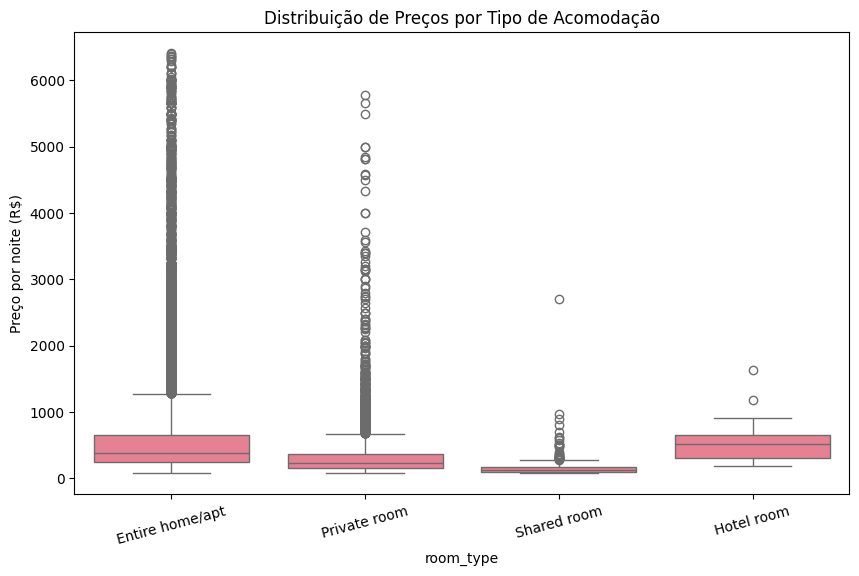

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_limpo, x='room_type', y='price')
plt.title('Distribuição de Preços por Tipo de Acomodação')
plt.xticks(rotation=15)
plt.ylabel('Preço por noite (R$)')
plt.show()

## Capítulo 7: O Poder do Status Superhost
Ser Superhost vale a pena? Vamos aos números para descobrir se esse badge dourado realmente se traduz em mais dinheiro no bolso.

In [22]:
print("\n=== SUPERHOST: INVESTIMENTO QUE VALE A PENA? ===\n")

superhost_stats = (df_limpo.groupby('host_is_superhost')
                   .agg({
                       'price': ['median', 'mean'],
                       'occupancy_rate': 'mean',
                       'number_of_reviews': 'mean',
                       'review_scores_rating': 'mean'
                   }).round(2))

superhost_stats.columns = ['mediana_preco', 'media_preco', 'ocupacao_media',
                          'reviews_media', 'nota_media']

# Calculando o premium do Superhost
premium_superhost = ((superhost_stats.loc[True, 'mediana_preco'] /
                      superhost_stats.loc[False, 'mediana_preco'] - 1) * 100)

print("Comparativo Superhost vs Anfitrião Comum:")
print(f"• Premium de preço: +{premium_superhost:.1f}%")
print(f"• Ocupação Superhost: {superhost_stats.loc[True, 'ocupacao_media']:.1%}")
print(f"• Ocupação Comum: {superhost_stats.loc[False, 'ocupacao_media']:.1%}")


=== SUPERHOST: INVESTIMENTO QUE VALE A PENA? ===

Comparativo Superhost vs Anfitrião Comum:
• Premium de preço: +-14.7%
• Ocupação Superhost: 55.0%
• Ocupação Comum: 40.0%


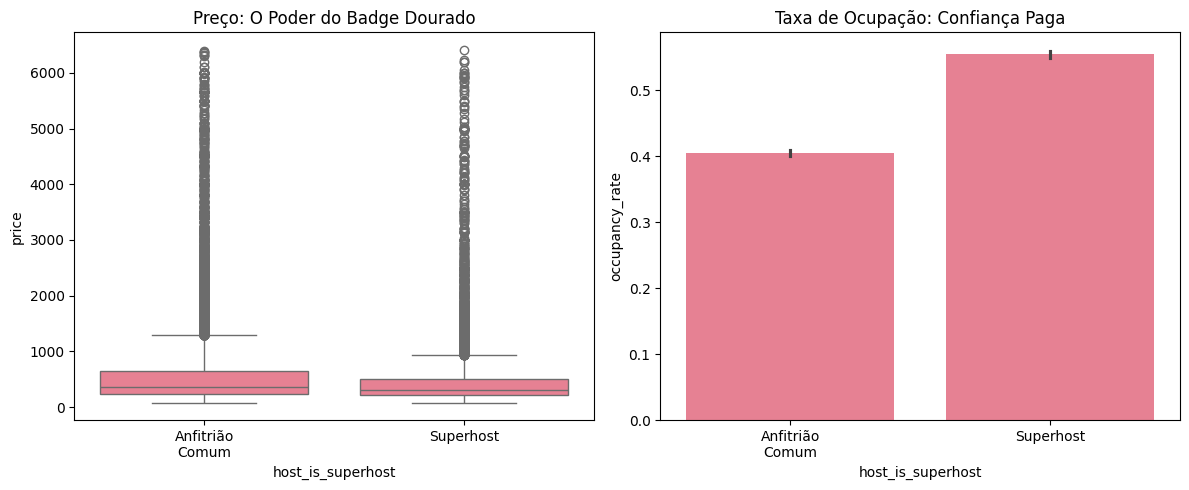

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_limpo, x='host_is_superhost', y='price')
plt.title('Preço: O Poder do Badge Dourado')
plt.xticks([0, 1], ['Anfitrião\nComum', 'Superhost'])

plt.subplot(1, 2, 2)
sns.barplot(data=df_limpo, x='host_is_superhost', y='occupancy_rate')
plt.title('Taxa de Ocupação: Confiança Paga')
plt.xticks([0, 1], ['Anfitrião\nComum', 'Superhost'])

plt.tight_layout()
plt.show()

## Capítulo 8: As Conexões Secretas
Quais fatores realmente influenciam o preço? Hora de descobrir as correlações que podem guiar sua estratégia.

In [24]:
print("\n=== DESCOBRINDO AS CORRELAÇÕES SECRETAS ===\n")

# Preparando dados para análise de correlação
corr_data = df_limpo[['price', 'accommodates', 'bedrooms', 'occupancy_rate',
                     'number_of_reviews', 'review_scores_rating']].dropna()

correlations = corr_data.corr()['price'].sort_values(ascending=False)

print("Correlações com preço (mais forte = mais impacto):")
for var, corr in correlations.items():
    if var != 'price':
        emoji = "🔥" if abs(corr) > 0.3 else "📊" if abs(corr) > 0.1 else "🔹"
        print(f"{emoji} {var}: {corr:.3f}")


=== DESCOBRINDO AS CORRELAÇÕES SECRETAS ===

Correlações com preço (mais forte = mais impacto):
🔥 bedrooms: 0.456
🔥 accommodates: 0.417
🔹 review_scores_rating: 0.023
🔹 occupancy_rate: -0.072
🔹 number_of_reviews: -0.086


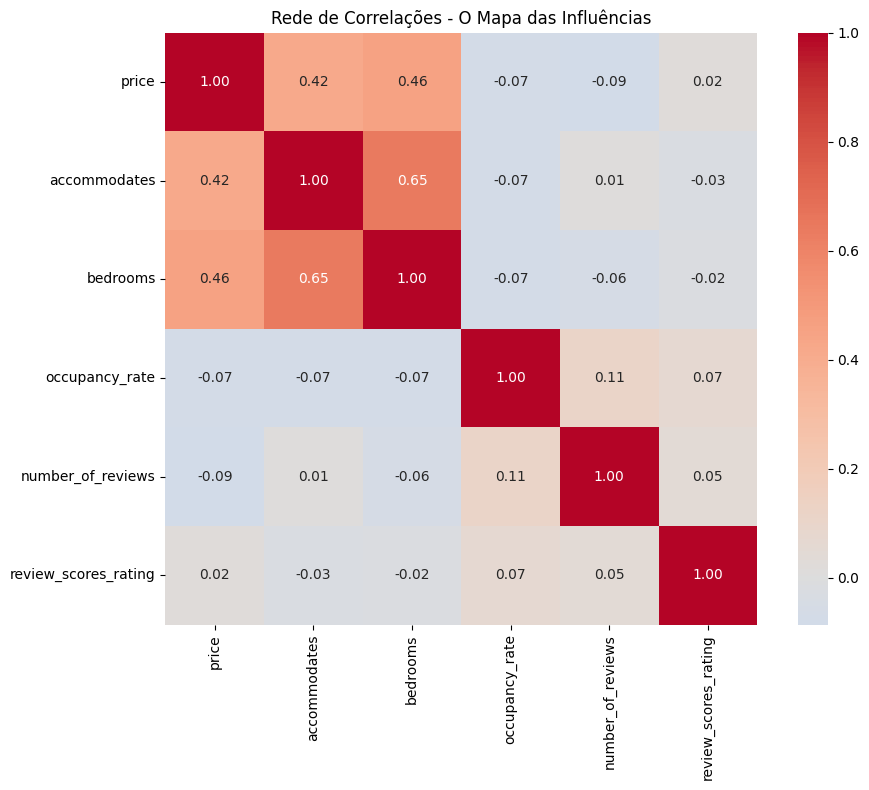

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Rede de Correlações - O Mapa das Influências')
plt.tight_layout()
plt.show()

## Capítulo 9: A Equação da Satisfação
Existe relação entre a qualidade (nota dos hóspedes) e o preço que você pode cobrar? Vamos investigar se vale a pena investir na experiência do cliente.

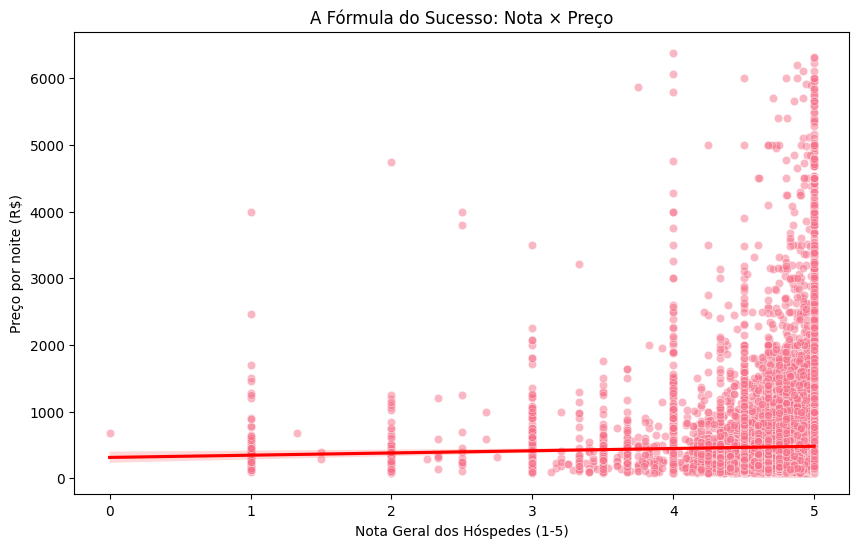

💡 Correlação nota-preço: 0.023


In [26]:
plt.figure(figsize=(10, 6))
review_data = df_limpo.dropna(subset=['review_scores_rating'])

sns.scatterplot(data=review_data, x='review_scores_rating', y='price', alpha=0.5)
sns.regplot(data=review_data, x='review_scores_rating', y='price',
           scatter=False, color='red')

plt.title('A Fórmula do Sucesso: Nota × Preço')
plt.xlabel('Nota Geral dos Hóspedes (1-5)')
plt.ylabel('Preço por noite (R$)')
plt.show()

# Calculando correlação
corr_rating_price = review_data[['review_scores_rating', 'price']].corr().iloc[0,1]
print(f"💡 Correlação nota-preço: {corr_rating_price:.3f}")

## Capítulo Final: O Guia do Sucesso
Chegamos ao fim de nossa jornada pelos dados. Hora de consolidar os insights que podem transformar sua estratégia no Airbnb carioca.

In [27]:
print("\n" + "="*50)
print("RESUMO EXECUTIVO")
print("="*50)

# Estatísticas principais
mediana_preco = df_limpo['price'].median()
ocupacao_media = df_limpo['occupancy_rate'].mean()
bairro_mais_caro = bairros_stats.index[0]
preco_bairro_caro = bairros_stats.iloc[0]['mediana_preco']

print(f"PANORAMA GERAL:")
print(f"   • Propriedades analisadas: {len(df_limpo):,}")
print(f"   • Preço mediano do mercado: R$ {mediana_preco:.0f}")
print(f"   • Taxa de ocupação média: {ocupacao_media:.1%}")

print(f"\nCHAMPIONS LEAGUE:")
print(f"   • Bairro mais lucrativo: {bairro_mais_caro}")
print(f"   • Preço mediano top: R$ {preco_bairro_caro:.0f}")

print(f"\nVANTAGEM SUPERHOST:")
premium = ((superhost_stats.loc[True, 'mediana_preco'] /
            superhost_stats.loc[False, 'mediana_preco'] - 1) * 100)
print(f"   • Premium de preço: +{premium:.1f}%")
print(f"   • Ocupação superior: +{((superhost_stats.loc[True, 'ocupacao_media'] / superhost_stats.loc[False, 'ocupacao_media'] - 1) * 100):.1f}%")

print(f"\nESTRATÉGIAS DE OURO:")
print(f"   • Foque em apartamentos inteiros")
print(f"   • Invista na localização (bairros nobres pagam mais)")
print(f"   • Busque o status Superhost")
print(f"   • Qualidade da experiência influencia preço")

print(f"\nAnálise concluída!")


RESUMO EXECUTIVO
PANORAMA GERAL:
   • Propriedades analisadas: 37,420
   • Preço mediano do mercado: R$ 342
   • Taxa de ocupação média: 45.5%

CHAMPIONS LEAGUE:
   • Bairro mais lucrativo: Leblon
   • Preço mediano top: R$ 596

VANTAGEM SUPERHOST:
   • Premium de preço: +-14.7%
   • Ocupação superior: +37.5%

ESTRATÉGIAS DE OURO:
   • Foque em apartamentos inteiros
   • Invista na localização (bairros nobres pagam mais)
   • Busque o status Superhost
   • Qualidade da experiência influencia preço

Análise concluída!


## Persistir os Dados Limpos

In [34]:
# Opcional: salvar o dataset limpo para análises futuras
df_limpo.to_csv('airbnb_rio_insights.csv', index=False)
print("✅ Dataset pronto para novas análises!")

✅ Dataset pronto para novas análises!
